<a href="https://colab.research.google.com/github/Surendra58/AI/blob/master/WiMLDS_Mysusru_COVID_19_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Topic: COVID-19 DATA MODELLING 

Installing and importing the necessary libraries. 

In [ ]:
!pip install optuna

In [ ]:
!pip install wget

In [ ]:
from datetime import datetime
time_format = "%d%b%Y %H:%M"
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import os
from pprint import pprint
import warnings
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
from scipy.integrate import odeint
import numpy as np
import optuna
optuna.logging.disable_default_handler()
import pandas as pd
pd.plotting.register_matplotlib_converters()
import seaborn as sns
from scipy.integrate import solve_ivp
import requests
import json
import pandas as pd
from pandas.io.json import json_normalize
import wget

##Infectious Disease Modelling 



*   Spreads from one person to other in a population
*   In order to understand the spread, use compartmental model
    - Suscpetible
    - Infected
    - Recovered

N: total population

S(t): number of people susceptible on day t   

I(t): number of people infected on day t

R(t): number of people recovered on day t

β: expected amount of people an infected person infects per day

e.g. Probability that an infected person infects a susceptible person = 25%
     and per day an infected person meets 4 susceptible then on a single day this infected person infects 1 (25% * 4)

D: number of days an infected person has and can spread the disease

γ: the proportion of infected recovering per day (γ = 1/D)

(1 person ---> has the disease for D days/ recovers after D days 
therefore,
in one day how many people recover? With cross multiplication we get it as 1/D)

R₀: the total number of people an infected person infects (R₀ = β / γ)
  

![alt text](https://drive.google.com/uc?export=view&id=1evqjPkS0N3uIOCHOmOdbe5BJvCxRmZxy)

![alt text](https://drive.google.com/uc?export=view&id=1zgWMGsIhJXdlwI0kHefSOfC20ICBGDwz)


*   Adding two more compartments:
    - Exposed
    - Death




E(t): number of people exposed on day t

D(t): number of people dead on day t

δ: length of incubation period

α: fatality rate

ρ: rate at which people die (= 1/days from infected until death)

![alt text](https://drive.google.com/uc?export=view&id=1CS85a4TXN73_DchOnmL4mYPF3mU6qvts)

![alt text](https://drive.google.com/uc?export=view&id=1kPac9Fhr1UwOSvX9ts3wyUnNNNBd3N9n)








In [ ]:
def plotseird(t, S, E, I, R, D=None):
  f, ax = plt.subplots(1,1,figsize=(10,4))
  ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
  ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
  ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
  ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
  if D is not None:
    ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    ax.plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')
  else:
    ax.plot(t, S+E+I+R, 'c--', alpha=0.7, linewidth=2, label='Total')

  ax.set_xlabel('Time (days)')

  ax.yaxis.set_tick_params(length=0)
  ax.xaxis.set_tick_params(length=0)
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')
  legend = ax.legend(borderpad=2.0)
  legend.get_frame().set_alpha(0.5)
  for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)
  plt.show();

In [ ]:
def deriv(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

In [ ]:
N = 1000000
D = 4.0 # infections lasts four days
gamma = 1.0 / D
delta = 1.0 / 5.0  # incubation period of five days
R_0 = 5.0
beta = R_0 * gamma  # R_0 = beta / gamma, so beta = R_0 * gamma
alpha = 0.2  # 20% death rate
rho = 1/9  # 9 days from infection until death
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed

In [ ]:
t = np.linspace(0, 99, 100) # Grid of time points (in days)
y0 = S0, E0, I0, R0, D0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))
S, E, I, R, D = ret.T

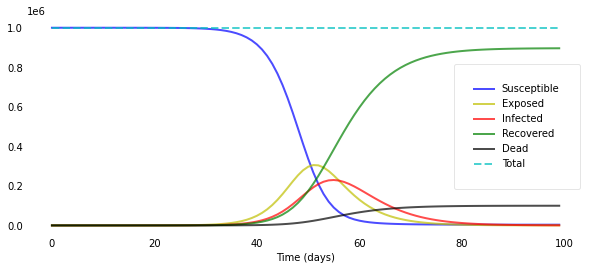

In [ ]:
plotseird(t, S, E, I, R, D)

Now, let us do for India data. 

Loading data from Kaggle using API. 
Data source: https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset

In [ ]:
!mkdir /root/.kaggle

In [ ]:
import json
token = {"username":"karthikakamath","key":"---"}
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [ ]:
!cp /root/.kaggle/kaggle.json ~/.kaggle/kaggle.json

cp: '/root/.kaggle/kaggle.json' and '/root/.kaggle/kaggle.json' are the same file


In [ ]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d sudalairajkumar/novel-corona-virus-2019-dataset -p /content

  0% 0.00/2.03M [00:00<?, ?B/s]
100% 2.03M/2.03M [00:00<00:00, 67.9MB/s]


In [ ]:
!unzip \*.zip

Archive:  novel-corona-virus-2019-dataset.zip
  inflating: COVID19_line_list_data.csv  
  inflating: COVID19_open_line_list.csv  
  inflating: covid_19_data.csv       
  inflating: time_series_covid_19_confirmed.csv  
  inflating: time_series_covid_19_confirmed_US.csv  
  inflating: time_series_covid_19_deaths.csv  
  inflating: time_series_covid_19_deaths_US.csv  
  inflating: time_series_covid_19_recovered.csv  


In [ ]:
raw = pd.read_csv("covid_19_data.csv")
raw.tail()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
68553,68554,07/20/2020,Zaporizhia Oblast,Ukraine,2020-07-21 04:38:46,678.0,20.0,551.0
68554,68555,07/20/2020,Zeeland,Netherlands,2020-07-21 04:38:46,791.0,69.0,0.0
68555,68556,07/20/2020,Zhejiang,Mainland China,2020-07-21 04:38:46,1270.0,1.0,1267.0
68556,68557,07/20/2020,Zhytomyr Oblast,Ukraine,2020-07-21 04:38:46,1602.0,34.0,1251.0
68557,68558,07/20/2020,Zuid-Holland,Netherlands,2020-07-21 04:38:46,11886.0,1305.0,0.0


In [ ]:
data_cols = ["Infected", "Deaths", "Recovered"]
variable_dict = {"Susceptible": "S", "Infected": "I", "Recovered": "R", "Deaths": "D"}
ncov_df = raw.rename({"ObservationDate": "Date", "State": "State"}, axis=1)
ncov_df["Date"] = pd.to_datetime(ncov_df["Date"])
ncov_df["Country"] = ncov_df["Country/Region"]
ncov_df["State"] = ncov_df["Province/State"].fillna("-")
ncov_df["Infected"] = ncov_df["Confirmed"] - ncov_df["Deaths"] - ncov_df["Recovered"]
ncov_df[data_cols] = ncov_df[data_cols].astype(np.int64)
ncov_df = ncov_df.loc[:, ["Date", "Country", "State", *data_cols]]

In [ ]:
ncov_df.loc[ncov_df['Country'] == 'India']

,Date,Country,State,Infected,Deaths,Recovered
430,2020-01-30,India,-,1,0,0
491,2020-01-31,India,-,1,0,0
547,2020-02-01,India,-,1,0,0
607,2020-02-02,India,-,2,0,0
672,2020-02-03,India,-,3,0,0
...,...,...,...,...,...,...
68486,2020-07-20,India,Tripura,1227,7,1845
68500,2020-07-20,India,Unknown,163,0,0
68509,2020-07-20,India,Uttar Pradesh,19137,1192,30831
68510,2020-07-20,India,Uttarakhand,1375,55,3212


In [ ]:
ncov_df.loc[ncov_df['State'] == 'Maharashtra']

,Date,Country,State,Infected,Deaths,Recovered
39066,2020-06-10,India,Maharashtra,44860,3289,42638
39791,2020-06-11,India,Maharashtra,47980,3590,46078
40520,2020-06-12,India,Maharashtra,47980,3590,46078
41249,2020-06-13,India,Maharashtra,49628,3717,47796
41978,2020-06-14,India,Maharashtra,51392,3830,49346
42707,2020-06-15,India,Maharashtra,50567,4128,56049
43436,2020-06-16,India,Maharashtra,50057,5537,57851
44165,2020-06-17,India,Maharashtra,51935,5651,59166
44894,2020-06-18,India,Maharashtra,53915,5751,60838
45623,2020-06-19,India,Maharashtra,55665,5893,62773


In [ ]:
india = ncov_df.drop(columns='State')
india = india.loc[india['Country'] == 'India']
india

,Date,Country,Infected,Deaths,Recovered
430,2020-01-30,India,1,0,0
491,2020-01-31,India,1,0,0
547,2020-02-01,India,1,0,0
607,2020-02-02,India,2,0,0
672,2020-02-03,India,3,0,0
...,...,...,...,...,...
68486,2020-07-20,India,1227,7,1845
68500,2020-07-20,India,163,0,0
68509,2020-07-20,India,19137,1192,30831
68510,2020-07-20,India,1375,55,3212


In [ ]:
india.reset_index(drop=True, inplace=True)

In [ ]:
india = india.groupby(india['Date'], as_index=False).sum()
india

,Date,Infected,Deaths,Recovered
0,2020-01-30,1,0,0
1,2020-01-31,1,0,0
2,2020-02-01,1,0,0
3,2020-02-02,2,0,0
4,2020-02-03,3,0,0
...,...,...,...,...
168,2020-07-16,342473,25602,635757
169,2020-07-17,359060,26273,653751
170,2020-07-18,373542,26816,677423
171,2020-07-19,390622,27497,700087


In [ ]:
def show_trend(ncov_df, variable="Confirmed", n_changepoints=4):
    """
    Show trend of log10(@variable) using fbprophet package.
    @ncov_df <pd.DataFrame>: the clean data
    @variable <str>: variable name to analyse
        - if Confirmed, use Infected + Recovered + Deaths
    @n_changepoints <int>: max number of change points
    """
    # Data arrangement
    df = ncov_df
    if variable == "Confirmed":
        df["Confirmed"] = df[["Infected", "Recovered", "Deaths"]].sum(axis=1)
    df = df.loc[:, ["Date", variable]]
    df.columns = ["ds", "y"]
    # Log10(x)
    warnings.resetwarnings()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        df["y"] = np.log10(df["y"]).replace([np.inf, -np.inf], 0)
    # fbprophet
    model = Prophet(growth="linear", daily_seasonality=False, n_changepoints=n_changepoints)
    model.fit(df)
    future = model.make_future_dataframe(periods=0)
    forecast = model.predict(future)
    # Create figure
    fig = model.plot(forecast)
    _ = add_changepoints_to_plot(fig.gca(), model, forecast)
    plt.title(f"log10({variable}) over time and change points")
    plt.ylabel(f"log10(the number of cases)")
    plt.xlabel("")

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


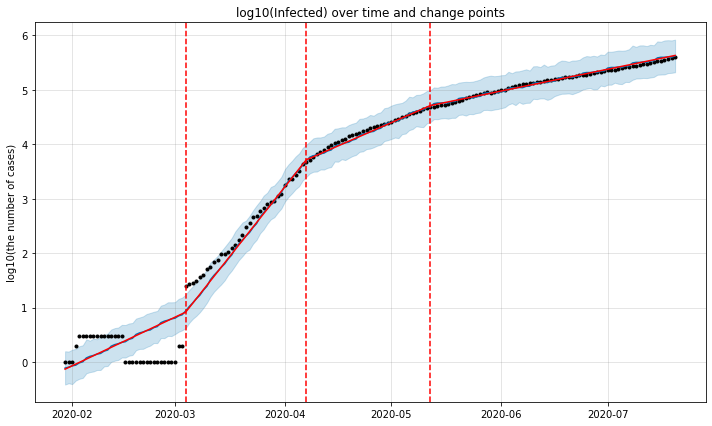

In [ ]:
show_trend(india, variable="Infected")

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


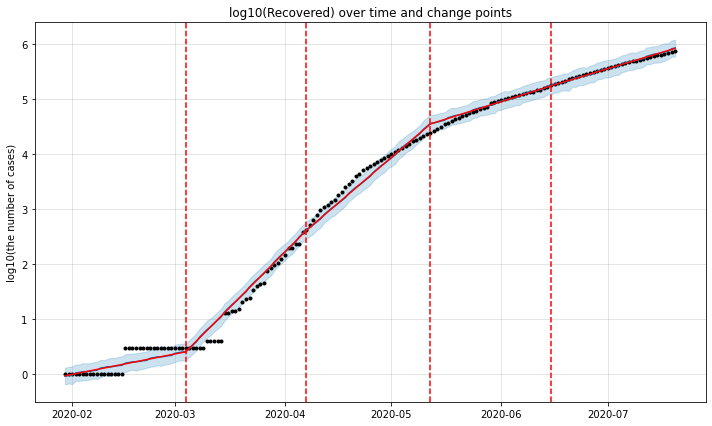

In [ ]:
show_trend(india, variable="Recovered")

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


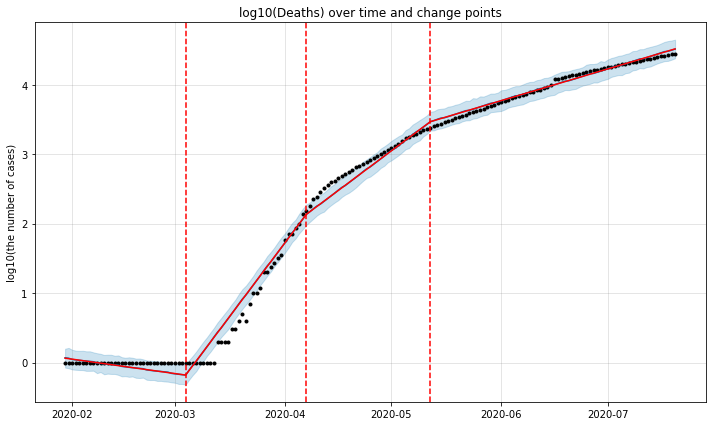

In [ ]:
show_trend(india, variable="Deaths")

In [ ]:
def line_plot(df, title, ylabel="Cases", h=None, v=None,
              xlim=(None, None), ylim=(0, None), math_scale=True, y_logscale=False, y_integer=False):
    """
    Show chlonological change of the data.
    """
    ax = df.plot()
    if math_scale:
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style="sci",  axis="y",scilimits=(0, 0))
    if y_logscale:
        ax.set_yscale("log")
    if y_integer:
        fmt = matplotlib.ticker.ScalarFormatter(useOffset=False)
        fmt.set_scientific(False)
        ax.yaxis.set_major_formatter(fmt)
    ax.set_title(title)
    ax.set_xlabel(None)
    ax.set_ylabel(ylabel)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.legend(bbox_to_anchor=(1.02, 0), loc="lower left", borderaxespad=0)
    if h is not None:
        ax.axhline(y=h, color="black", linestyle="--")
    if v is not None:
        if not isinstance(v, list):
            v = [v]
        for value in v:
            ax.axvline(x=value, color="black", linestyle="--")
    plt.show()

In [ ]:
def create_target_df(ncov_df, total_population, start_date=None, date_format="%d%b%Y"):
    """
    Select the records of the places, calculate the number of susceptible people,
     and calculate the elapsed time [day] from the start date of the target dataframe.
    @ncov_df <pd.DataFrame>: the clean data
    @total_population <int>: total population in the places
    @start_date <str>: the start date or None
    @date_format <str>: format of @start_date
    @return <tuple(2 objects)>:
        - 1. start_date <pd.Timestamp>: the start date of the selected records
        - 2. target_df <pd.DataFrame>:
            - column T: elapsed time [min] from the start date of the dataset
            - column Susceptible: the number of patients who are in the palces but not infected/recovered/died
            - column Infected: the number of infected cases
            - column Recovered: the number of recovered cases
            - column Deaths: the number of death cases
    """
    # Select the target records
    df = ncov_df
    if start_date is not None:
        df = df.loc[df["Date"] > datetime.strptime(start_date, date_format), :]
    start_date = df.loc[df.index[0], "Date"]
    # column T
    df["T"] = ((df["Date"] - start_date).dt.total_seconds() / 60).astype(int)
    # coluns except T
    df["Susceptible"] = total_population - df["Infected"] - df["Recovered"] - df["Deaths"]
    response_variables = ["Susceptible", "Infected", "Recovered", "Deaths"]
    # Return
    target_df = df.loc[:, ["T", *response_variables]]
    return (start_date, target_df)

In [ ]:
def simulation(model, initials, step_n, **params):
    """
    Solve ODE of the model.
    @model <ModelBase>: the model
    @initials <tuple[float]>: the initial values
    @step_n <int>: the number of steps
    """
    tstart, dt, tend = 0, 1, step_n
    sol = solve_ivp(
        fun=model(**params),
        # Implicit Runge-Kutta method of the Radau IIA family of order 5
        # method="Radau",
        t_span=[tstart, tend],
        y0=np.array(initials, dtype=np.float64),
        t_eval=np.arange(tstart, tend + dt, dt),
        dense_output=True
    )
    t_df = pd.Series(data=sol["t"], name="t")
    y_df = pd.DataFrame(data=sol["y"].T.copy(), columns=model.VARIABLES)
    sim_df = pd.concat([t_df, y_df], axis=1)
    return sim_df

In [ ]:
class Estimator(object):
    def __init__(self, model, ncov_df, total_population, name=None, start_date=None, date_format="%d%b%Y", **kwargs):
        """
        Set training data.
        @model <ModelBase>: the model
        @name <str>: name of the area
        @kwargs: fixed parameter of the model
        @the other params: See the function named create_target_df()
        """
        self.fixed_param_dict = kwargs.copy()
        dataset = model.create_dataset(
            ncov_df, total_population,
            start_date=start_date, date_format=date_format
        )
        self.start_time, self.initials, self.Tend, self.train_df = dataset
        self.total_population = total_population
        self.name = name
        self.model = model
        self.param_dict = dict()
        self.study = None
        self.optimize_df = None

    def run(self, n_trials=500):
        """
        Try estimation (optimization of parameters and tau).
        @n_trials <int>: the number of trials
        """
        if self.study is None:
            self.study = optuna.create_study(direction="minimize", pruner= optuna.pruners.HyperbandPruner)
        self.study.optimize(
            lambda x: self.objective(x),
            n_trials=n_trials,
            n_jobs=-1
        )
        param_dict = self.study.best_params.copy()
        param_dict.update(self.fixed_param_dict)
        param_dict["R0"] = self.calc_r0()
        param_dict["score"] = self.score()
        param_dict.update(self.calc_days_dict())
        self.param_dict = param_dict.copy()
        return param_dict

    def objective(self, trial):
        # Time
        if "tau" in self.fixed_param_dict.keys():
            tau = self.fixed_param_dict["tau"]
        else:
            tau = trial.suggest_int("tau", 1, 1440)
        # Apply adjusted Exponential Moving Average on the training data
        #.set_index("T").ewm(span=7, adjust=True).mean().reset_index()
        train_df_divided = self.train_df.copy()
        train_df_divided["t"] = (train_df_divided["T"] / tau).astype(np.int64) # int to np.int64
        # Parameters
        p_dict = dict()
        for (name, info) in self.model.param_dict(train_df_divided).items():
            if name in self.fixed_param_dict.keys():
                param = self.fixed_param_dict[name]
            elif info[0] == "float":
                param = trial.suggest_uniform(name, info[1], info[2])
            else:
                param = trial.suggest_int(name, info[1], info[2])
            p_dict[name] = param
        # Simulation
        t_end = train_df_divided.loc[train_df_divided.index[-1], "t"]
        sim_df = simulation(self.model, self.initials, step_n=t_end, **p_dict)
        return self.error_f(train_df_divided, sim_df)

    def error_f(self, train_df_divided, sim_df):
        """
        We need to minimize the difference of the observed values and estimated values.
        This function calculate the difference of the estimated value and obsereved value.
        """
        df = pd.merge(train_df_divided, sim_df, on="t", suffixes=("_observed", "_estimated"))
        diffs = [
            # Weighted Average: the recent data is more important
            p * np.average(
                abs(df[f"{v}_observed"] - df[f"{v}_estimated"]) / (df[f"{v}_observed"] * self.total_population + 1),
                weights=df["t"]
            )
            for (p, v) in zip(self.model.PRIORITIES, self.model.VARIABLES)
        ]
        return sum(diffs) * (self.total_population ** 2)

    def compare_df(self):
        """
        Show the taining data and simulated data in one dataframe.
        
        """
        est_dict = self.study.best_params.copy()
        est_dict.update(self.fixed_param_dict)
        tau = est_dict["tau"]
        est_dict.pop("tau")
        observed_df = self.train_df.drop("T", axis=1)
        observed_df["t"] = (self.train_df["T"] / tau).astype(int)
        t_end = observed_df.loc[observed_df.index[-1], "t"]
        sim_df = simulation(self.model, self.initials, step_n=t_end, **est_dict)
        df = pd.merge(observed_df, sim_df, on="t", suffixes=("_observed", "_estimated"))
        df = df.set_index("t")
        return df

    def compare_graph(self):
        """
        Compare obsereved and estimated values in graphs.
        """
        df = self.compare_df()
        use_variables = [
            v for (i, (p, v)) in enumerate(zip(self.model.PRIORITIES, self.model.VARIABLES))
            if p != 0 and i != 0
        ]
        val_len = len(use_variables) + 1
        fig, axes = plt.subplots(ncols=1, nrows=val_len, figsize=(9, 6 * val_len / 2))
        for (ax, v) in zip(axes.ravel()[1:],use_variables):
            df[[f"{v}_observed", f"{v}_estimated"]].plot.line(
                ax=ax, ylim=(0, None), sharex=True,
                title=f"{self.model.NAME}: Comparison of observed/estimated {v}(t)"
            )
            ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
            ax.ticklabel_format(style="sci",  axis="y",scilimits=(0, 0))
            ax.legend(bbox_to_anchor=(1.02, 0), loc="lower left", borderaxespad=0)
        for v in use_variables:
            df[f"{v}_diff"] = df[f"{v}_observed"] - df[f"{v}_estimated"]
            df[f"{v}_diff"].plot.line(
                ax=axes.ravel()[0], sharex=True,
                title=f"{self.model.NAME}: observed - estimated"
            )
        axes.ravel()[0].axhline(y=0, color="black", linestyle="--")
        axes.ravel()[0].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        axes.ravel()[0].ticklabel_format(style="sci",  axis="y",scilimits=(0, 0))
        axes.ravel()[0].legend(bbox_to_anchor=(1.02, 0), loc="lower left", borderaxespad=0)
        fig.tight_layout()
        fig.show()
    
    def calc_r0(self):
        """
        Calculate R0.
        """
        est_dict = self.study.best_params.copy()
        est_dict.update(self.fixed_param_dict)
        est_dict.pop("tau")
        model_instance = self.model(**est_dict)
        return model_instance.calc_r0()

    def calc_days_dict(self):
        """
        Calculate 1/beta etc.
        """
        est_dict = self.study.best_params.copy()
        est_dict.update(self.fixed_param_dict)
        tau = est_dict["tau"]
        est_dict.pop("tau")
        model_instance = self.model(**est_dict)
        return model_instance.calc_days_dict(tau)


    def score(self):
        """
        Return the sum of differences of observed and estimated values devided by the number of steps.
        """
        variables = self.model.VARIABLES[:]
        compare_df = self.compare_df()
        score = 0
        for v in variables:
            score += abs(compare_df[f"{v}_observed"] - compare_df[f"{v}_estimated"]).sum()
        score = score / len(compare_df)
        return score

    def info(self):
        """
        Return Estimater information.
        @return <tupple[object]>:
            - <ModelBase>: model
            - <dict[str]=str>: name, total_population, start_time, tau
            - <dict[str]=float>: values of parameters of model
        """
        param_dict = self.study.best_params.copy()
        param_dict.update(self.fixed_param_dict)
        info_dict = {
            "name": self.name,
            "total_population": self.total_population,
            "start_time": self.start_time,
            "tau": param_dict["tau"],
            "initials": self.initials
        }
        param_dict.pop("tau")
        return (self.model, info_dict, param_dict)

In [ ]:
class ModelBase(object):
    NAME = "Model"
    VARIABLES = ["x"]
    PRIORITIES = np.array([1])
    QUANTILE_RANGE = [0.3, 0.7]

    @classmethod
    def param_dict(cls, train_df_divided=None, q_range=None):
        """
        Define parameters without tau. This function should be overwritten.
        @train_df_divided <pd.DataFrame>:
            - column: t and non-dimensional variables
        @q_range <list[float, float]>: quantile rage of the parameters calculated by the data
        @return <dict[name]=(type, min, max):
            @type <str>: "float" or "int"
            @min <float/int>: min value
            @max <float/int>: max value
        """
        param_dict = dict()
        return param_dict

    @staticmethod
    def calc_variables(df):
        """
        Calculate the variables of the model.
        This function should be overwritten.
        @df <pd.DataFrame>
        @return <pd.DataFrame>
        """
        return df

    @staticmethod
    def calc_variables_reverse(df):
        """
        Calculate measurable variables using the variables of the model.
        This function should be overwritten.
        @df <pd.DataFrame>
        @return <pd.DataFrame>
        """
        return df

    @classmethod
    def create_dataset(cls, ncov_df, total_population, start_date=None, date_format="%d%b%Y"):
        """
        Create dataset with the model-specific varibles.
        The variables will be divided by total population.
        The column names (not include T) will be lower letters.
        @params: See the function named create_target_df()
        @return <tuple(objects)>:
            - start_date <pd.Timestamp>
            - initials <tuple(float)>: the initial values
            - Tend <int>: the last value of T
            - df <pd.DataFrame>: the dataset
        """
        start_date, target_df = create_target_df(
            ncov_df, total_population,
            start_date=start_date, date_format=date_format
        )
        df = cls.calc_variables(target_df).set_index("T") / total_population
        df.columns = [n.lower() for n in df.columns]
        initials = df.iloc[0, :].values
        df = df.reset_index()
        Tend = df.iloc[-1, 0]
        return (start_date, initials, Tend, df)

    def calc_r0(self):
        """
        Calculate R0. This function should be overwritten.
        """
        return None

    def calc_days_dict(self, tau):
        """
        Calculate 1/beta [day] etc.
        This function should be overwritten.
        @param tau <int>: tau value [hour]
        """
        return dict()

![alt text](https://drive.google.com/uc?export=view&id=1KHa1PUCfp7Y6RsDc2vElJFbHA2kmRhCI)

In [ ]:
class SIRD(ModelBase):
    NAME = "SIR-D"
    VARIABLES = ["x", "y", "z", "w"]
    PRIORITIES = np.array([1, 10, 10, 2])

    def __init__(self, kappa, rho, sigma):
        super().__init__()
        self.kappa = float(kappa)
        self.rho = float(rho)
        self.sigma = float(sigma)

    def __call__(self, t, X):
        dxdt = - self.rho * X[0] * X[1]
        dydt = self.rho * X[0] * X[1] - (self.sigma + self.kappa) * X[1]
        dzdt = self.sigma * X[1]
        dwdt = self.kappa * X[1]
        return np.array([dxdt, dydt, dzdt, dwdt])

    @classmethod
    def param_dict(cls, train_df_divided=None, q_range=None):
        param_dict = super().param_dict()
        q_range = super().QUANTILE_RANGE[:] if q_range is None else q_range
        if train_df_divided is None:
            param_dict["kappa"] = ("float", 0, 1)
            param_dict["rho"] = ("float", 0, 1)
            param_dict["sigma"] = ("float", 0, 1)
        else:
            df = train_df_divided.copy()
            # kappa = (dw/dt) / y
            kappa_series = df["w"].diff() / df["t"].diff() / df["y"]
            param_dict["kappa"] = ("float", *kappa_series.quantile(q_range))
            # rho = - (dx/dt) / x / y
            rho_series = 0 - df["x"].diff() / df["t"].diff() / df["x"] / df["y"]
            param_dict["rho"] = ("float", *rho_series.quantile(q_range))
            # sigma = (dz/dt) / y
            sigma_series = df["z"].diff() / df["t"].diff() / df["y"]
            param_dict["sigma"] = ("float", *sigma_series.quantile(q_range))
        return param_dict

    @staticmethod
    def calc_variables(df):
        df["X"] = df["Susceptible"]
        df["Y"] = df["Infected"]
        df["Z"] = df["Recovered"]
        df["W"] = df["Deaths"]
        return df.loc[:, ["T", "X", "Y", "Z", "W"]]

    @staticmethod
    def calc_variables_reverse(df):
        df["Susceptible"] = df["X"]
        df["Infected"] = df["Y"]
        df["Recovered"] = df["Z"]
        df["Deaths"] = df["W"]
        return df

    def calc_r0(self):
        try:
            r0 = self.rho / (self.sigma + self.kappa)
        except ZeroDivisionError:
            return np.nan
        return round(r0, 2)


    def calc_days_dict(self, tau):
        _dict = dict()
        if self.kappa == 0:
            _dict["1/alpha2 [day]"] = 0
        else:
            _dict["1/alpha2 [day]"] = int(tau / 24 / 60 / self.kappa)
        _dict["1/beta [day]"] = int(tau / 24 / 60 / self.rho)
        if self.sigma == 0:
            _dict["1/gamma [day]"] = 0
        else:
            _dict["1/gamma [day]"] = int(tau / 24 / 60 / self.sigma)
        return _dict

In [ ]:
class Predicter(object):
    """
    Predict the future using models.
    """
    def __init__(self, name, total_population, start_time, tau, initials, date_format="%d%b%Y"):
        """
        @name <str>: place name
        @total_population <int>: total population
        @start_time <datatime>: the start time
        @tau <int>: tau value (time step)
        @initials <list/tupple/np.array[float]>: initial values of the first model
        @date_format <str>: date format to display in figures
        """
        self.name = name
        self.total_population = total_population
        self.start_time = start_time
        self.tau = tau
        self.date_format = date_format
        # Un-fixed
        self.last_time = start_time
        self.axvlines = list()
        self.initials = initials
        self.df = pd.DataFrame()
        self.title_list = list()
        self.reverse_f = lambda x: x

    def add(self, model, end_day_n=None, count_from_last=False, vline=True, **param_dict):
        """
        @model <ModelBase>: the epidemic model
        @end_day_n <int/None>: day number of the end date (0, 1, 2,...), or None (now)
            - if @count_from_last <bool> is True, start point will be the last date registered to Predicter
        @vline <bool>: if True, vertical line will be shown at the end date
        @**param_dict <dict>: keyword arguments of the model
        """
        # Validate day number, and calculate step number
        if end_day_n is None:
            end_time = datetime.now()
        else:
            if count_from_last:
                end_time = self.last_time + timedelta(days=end_day_n)
            else:
                end_time = self.start_time + timedelta(days=end_day_n)
        if end_time <= self.last_time:
            raise Exception(f"Model on {end_time.strftime(self.date_format)} has been registered!")
        step_n = int((end_time - self.last_time).total_seconds() / 60 / self.tau)
        self.last_time = end_time
        # Perform simulation
        new_df = simulation(model, self.initials, step_n=step_n, **param_dict)
        new_df["t"] = new_df["t"] + len(self.df)
        self.df = pd.concat([self.df, new_df], axis=0).fillna(0)
        self.initials = new_df.set_index("t").iloc[-1, :]
        # For title
        if vline:
            self.axvlines.append(end_time)
            r0 = model(**param_dict).calc_r0()
            self.title_list.append(
                #f"{model.NAME}({r0}, -{end_time.strftime(self.date_format)})"
                f"R0:{r0}, -{end_time.strftime(self.date_format)}"
            )
        # Update reverse function (X, Y,.. to Susceptible, Infected,...)
        self.reverse_f = model.calc_variables_reverse
        return self

    def restore_df(self):
        """
        Return the dimentional simulated data.
        @return <pd.DataFrame>
        """
        df = self.df.copy()
        df["Time"] = self.start_time + df["t"].apply(lambda x: timedelta(minutes=x * self.tau))
        df = df.drop("t", axis=1).set_index("Time") * self.total_population
        df = df.astype(np.int64)
        upper_cols = [n.upper() for n in df.columns]
        df.columns = upper_cols
        df = self.reverse_f(df).drop(upper_cols, axis=1)
        return df

    def restore_graph(self, drop_cols=None, **kwargs):
        """
        Show the dimentional simulate data as a figure.
        @drop_cols <list[str]>: the columns not to be shown
        @kwargs: keyword arguments of line_plot() function
        """
        df = self.restore_df()
        if drop_cols is not None:
            df = df.drop(drop_cols, axis=1)
        axvlines = [datetime.now(), *self.axvlines] if len(self.axvlines) == 1 else self.axvlines[:]
        line_plot(
            df,
            #title=f"{self.name}: {', '.join(self.title_list)}",
            title=f"{', '.join(self.title_list)}",
            v=axvlines[:-1],
            h=self.total_population,
            **kwargs
        )

In [ ]:
%%time

it_start = '10May2020'
pop = 1380004384

it_sird_estimator = Estimator(
    SIRD, india, pop, name="India",
    start_date=it_start
)
it_sird_dict = it_sird_estimator.run()

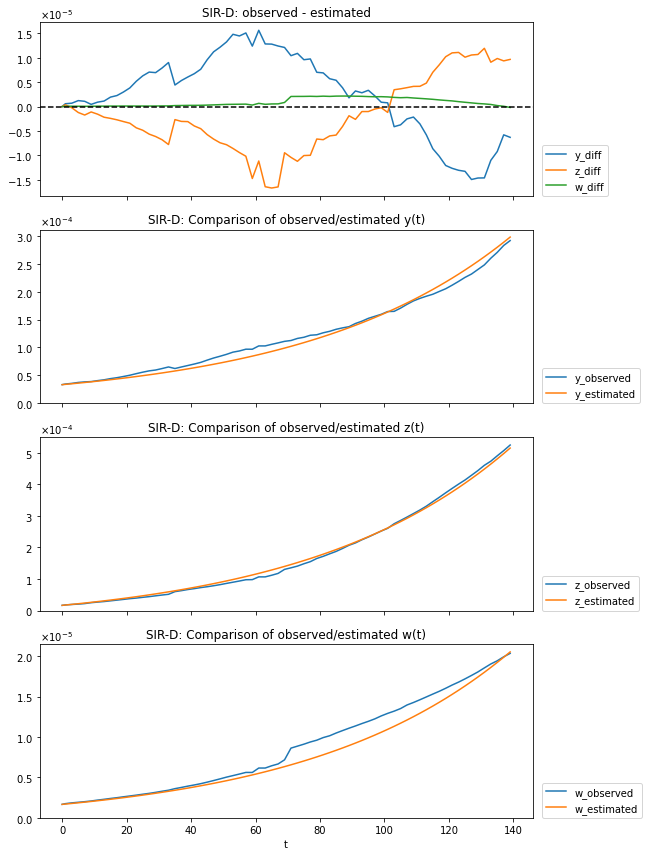

In [ ]:
it_sird_estimator.compare_graph()

In [ ]:
pd.DataFrame.from_dict({"SIRD": it_sird_dict}, orient="index").fillna("-")

,tau,kappa,rho,sigma,R0,score,1/alpha2 [day],1/beta [day],1/gamma [day]
SIRD,725,0.001123,0.046627,0.029716,1.51,0.000017,448,10,16


In [ ]:
first_model, info_dict, param_dict = it_sird_estimator.info()

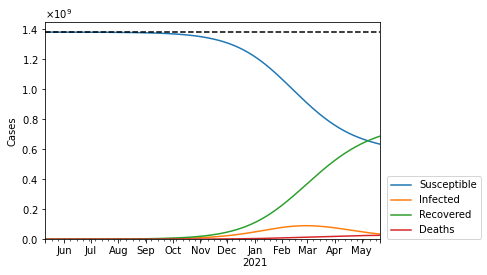

In [ ]:
predicter = Predicter(**info_dict)
predicter.add(first_model, end_day_n=None, count_from_last=False, vline=False, **param_dict)
predicter.add(first_model, end_day_n=300, count_from_last=True,vline=False, **param_dict)
predicter.restore_graph(drop_cols=None)

Here is a screenshot of an article from The KEN:

![alt text](https://drive.google.com/uc?export=view&id=1-cmgTqXLWD28n-cc5zS2Th7J_F5GePZ6)

My early model predicted this that obviously has expired: 
![alt text](https://drive.google.com/uc?export=view&id=18qFAayNt7d44k7etFP7izfzNu___849E)

![alt text](https://drive.google.com/uc?export=view&id=17IJaWUXbVM2Kabsax5Hui-vuBMdDpKfz)

![alt text](https://drive.google.com/uc?export=view&id=1mx3R8ZCRl8rNVsqYwlUP_3HDZQW1V2yL)

Thanks to these blogs and kernels:
1. https://www.kaggle.com/lisphilar/covid-19-data-with-sir-model/notebook
2. https://towardsdatascience.com/infectious-disease-modelling-beyond-the-basic-sir-model-216369c584c4
3. https://the-ken.com/story/indias-next-top-covid-model/

Bonus, try out an epidemic simulator for yourself here: https://ncase.me/covid-19/ 